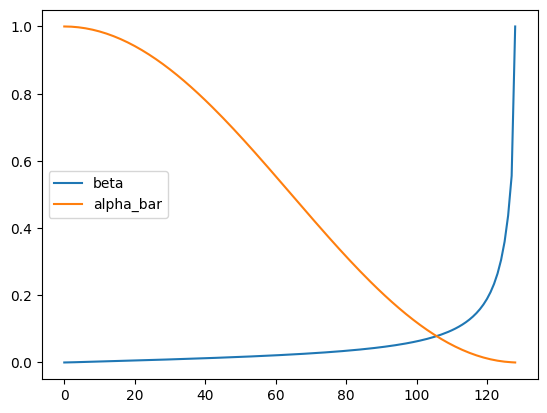

In [43]:
import stanza.runtime
stanza.runtime.setup() # setup logging, etc.

from functools import partial
import jax
import jax.flatten_util
import matplotlib.pyplot as plt
import jax.numpy as jnp

from stanza.data import PyTreeData
from stanza.diffusion import DDPMSchedule

schedule = DDPMSchedule.make_squaredcos_cap_v2(128, prediction_type="sample")
schedule.visualize().show()

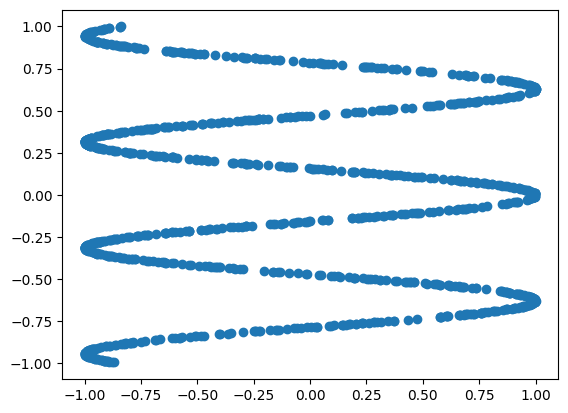

In [54]:
# Generate some data
data = "cosine"
if data == "cosine":
    def generate(rng_key: jax.Array) -> jax.Array:
        t = jax.random.uniform(rng_key, (), minval=-1, maxval=1)
        x = jnp.cos(10*t)
        return t, x
elif data == "spaces":
    space = 0.3
    diff = 0.9
    def generate(rng_key: jax.Array) -> jax.Array:
        t = jax.random.uniform(rng_key, (), minval=-1, maxval=1)
        t = (0.8-space)*t + space*jnp.sign(t)
        x = diff * jnp.sign(t)
        return t, x

train_data = jax.vmap(generate)(jax.random.split(jax.random.PRNGKey(42), 1024))
train_data = PyTreeData(train_data)
test_data = jax.vmap(generate)(jax.random.split(jax.random.PRNGKey(43), 1024))
test_data = PyTreeData(test_data)


plt.scatter(train_data.tree[0], train_data.tree[1])
plt.show()

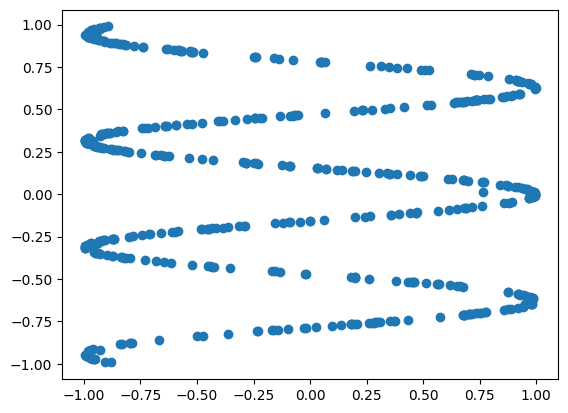

In [55]:
@jax.jit
def sample_gt(rng_key):
    def denoiser(rng_key, x, t):
        denoised_x = schedule.compute_denoised(x, t, train_data.tree)
        return schedule.output_from_denoised(x, t, denoised_x)
    return schedule.sample(
        rng_key,
        denoiser,
        train_data[0]
    )

# gt_sample = sample_gt(jax.random.PRNGKey(42), 1.0)
gt_samples = jax.vmap(sample_gt)(
    jax.random.split(jax.random.PRNGKey(42), 512),
)
plt.clf()
plt.scatter(gt_samples[0], gt_samples[1])
plt.show()

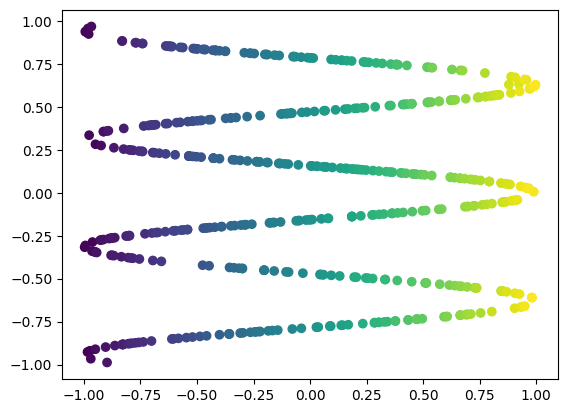

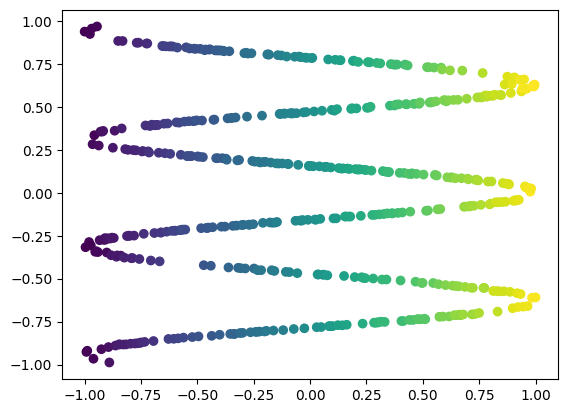

In [56]:
@jax.jit
def sample_gt(rng_key, cond):
    cond_traj, _ = schedule.forward_trajectory(rng_key, cond)
    def denoiser(rng_key, x, t):
        denoised_x = schedule.compute_denoised((cond_traj[t], x[1]), t, train_data.tree)
        return schedule.output_from_denoised(x, t, denoised_x)
    x, y = schedule.sample(
        rng_key,
        denoiser,
        train_data[0]
    )
    return cond, x, y

# gt_sample = sample_gt(jax.random.PRNGKey(42), 1.0)
gt_samples = jax.vmap(sample_gt)(
    jax.random.split(jax.random.PRNGKey(42), 512),
    jnp.linspace(-1, 1, 512)
)
plt.clf()
plt.scatter(gt_samples[1], gt_samples[2], c = gt_samples[0])
plt.show()
plt.clf()
plt.scatter(gt_samples[0], gt_samples[2], c = gt_samples[1])
plt.show()

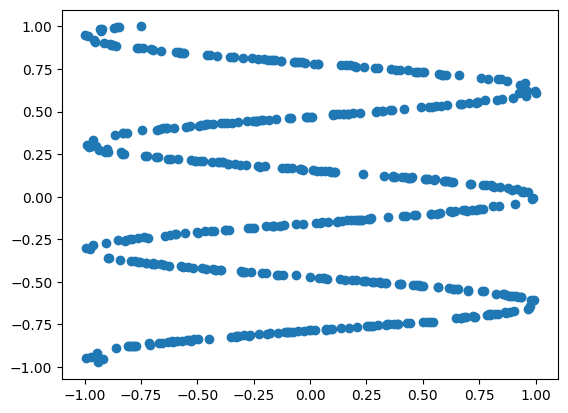

In [57]:
# The schedule also has the compute_denoised method
# which given a (small) dataset will compute the ground-truth model output!
# This is useful for debugging whether the denoiser has sufficient
# capacity to capture the true score function.

@jax.jit
def sample_gt(rng_key, cond):
    cond_traj, _ = schedule.forward_trajectory(rng_key, cond)
    def denoiser(rng_key, x, t):
        cond_noised = cond_traj[t]
        _, denoised_x = schedule.compute_denoised((cond_noised, x), t, train_data.tree)
        return schedule.output_from_denoised(x, t, denoised_x)
    return cond, schedule.sample(
        rng_key,
        denoiser,
        train_data[0][1]
    )

# gt_sample = sample_gt(jax.random.PRNGKey(42), 1.0)
gt_samples = jax.vmap(sample_gt)(
    jax.random.split(jax.random.PRNGKey(42), 512),
    jnp.linspace(-1, 1, 512)
)
plt.clf()
plt.scatter(gt_samples[0], gt_samples[1])
plt.show()